In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
import import_ipynb
import function_NGD_20201022
%matplotlib inline

importing Jupyter notebook from function_NGD_20201022.ipynb


In [2]:
# euler method
def ConeOutput(T_in,x,phi,beta_c):
    dt_in=T_in[1]-T_in[0]
    alpha_c=-9.602*10**-6
#     beta_c=-1.148*10**-5 #7*10**-3 
    alpha_h=2
    gamma=0.764
    tau_h=1.2
    tau_z=0.5769
    tau_y=0.056
    tau_c=0.05
    Tk=np.arange(0,5,dt_in)
    Ky=Tk*np.exp(-Tk/tau_y)/tau_y**2 # linear filter for low pass filter
    Kz=gamma*Ky+(1-gamma)*Tk*np.exp(-Tk/tau_z)/tau_z**2 # linear filter for adaptation
    Kh=Tk*np.exp(-Tk/tau_h)/tau_h**2
    # y
    y=np.convolve(x,Ky,'full')
    y=y[0:len(x)]
    # z
    z=np.convolve(x,Kz,'full')
    z=z[0:len(x)]
    # cone differential equation (include horizontal feedback)
#     phi=1
    r=np.zeros(len(x))
    h=np.zeros(len(x))
    yh=np.zeros(len(x))
    for i in range(len(x)-1): # the length of kernel should be i, original length of kernel is len(Kh)
        dr=(alpha_c*y[i]-(1+beta_c*z[i])*(r[i]+phi*h[i]))*dt_in/tau_c
        dh=(alpha_h*r[i]-h[i])*dt_in/tau_h
        r[i+1]=r[i]+dr
        h[i+1]=h[i]+dh
    return r,h,y,z

In [3]:
# Runge Kutta method
def ConeOutput_RK(T_in,x_in,phi,beta_c):
    dt=T_in[1]-T_in[0]
    alpha_c=-9.602*10**-6
#     beta_c=7*10**-3 #-1.148*10**-5
    alpha_h=0.7
    gamma=0.764
    tau_h=1.2
    tau_z=0.5769
    tau_y=0.065
    tau_c=0.05
    Tk=np.arange(0,5,dt)
    Ky=Tk*np.exp(-Tk/tau_y)/tau_y**2 # linear filter for low pass filter
    Kz=gamma*Ky+(1-gamma)*Tk*np.exp(-Tk/tau_z)/tau_z**2 # linear filter for adaptation
    Kh=Tk*np.exp(-Tk/tau_h)/tau_h**2
    # y
    y=np.convolve(x_in,Ky,'full')
    y=y[0:len(x_in)]
    # z
    z=np.convolve(x_in,Kz,'full')
    z=z[0:len(x_in)]
    # cone differential equation (include horizontal feedback)
    #     phi=1

    def drdt(t,rstep,hstep):
        t_index=int(t/dt)-1
        RK_r=(alpha_c*y[t_index]-(1+beta_c*z[t_index])*(rstep+phi*hstep))/tau_c
        return RK_r
    def dhdt(t,rstep,hstep):
        t_index=int(t/dt)-1
        RK_h=(alpha_h*rstep-hstep)/tau_h
        return RK_h
    
    # n_RK is the data point number of runge kutta output, the output collect a datapoint in two steps of input
    n_RK=math.floor((len(x_in)-2)/2)+1
    r=np.zeros(n_RK)
    h=np.zeros(n_RK)
    T_RK=np.zeros(n_RK)
    T_RK[0]=dt*2
    xRK=np.zeros(n_RK)
    xRK[0]=x_in[0]
    j=0
    for j in range(n_RK-1): 
        dh=dt*2
        i=2*j
        RK1_r=drdt(T_in[i],r[j],h[j])
        RK1_h=dhdt(T_in[i],r[j],h[j])
        RK2_r=drdt(T_in[i]+dh/2,r[j]+RK1_r/2*dh,h[j]+RK1_h/2*dh)
        RK2_h=drdt(T_in[i]+dh/2,r[j]+RK1_r/2*dh,h[j]+RK1_h/2*dh)
        RK3_r=drdt(T_in[i]+dh/2,r[j]+RK2_r/2*dh,h[j]+RK2_h/2*dh)
        RK3_h=drdt(T_in[i]+dh/2,r[j]+RK2_r/2*dh,h[j]+RK2_h/2*dh)
        RK4_r=drdt(T_in[i]+dh,r[j]+RK3_r*dh,h[j]+RK3_h*dh)
        RK4_h=drdt(T_in[i]+dh,r[j]+RK3_r*dh,h[j]+RK3_h*dh)
        r[j+1]=r[j]+1/6*dh*(RK1_r+2*RK2_r+2*RK3_r+RK4_r)
        h[j+1]=h[j]+1/6*dh*(RK1_h+2*RK2_h+2*RK3_h+RK4_h)
        T_RK[j+1]=T_RK[j]+dh
        xRK[j]=x_in[i]
    return T_RK,xRK,r,h

## Stimuli pattern

### on off increasing contrast

10.0 12.99
16.0 18.990000000000002
22.0 24.990000000000002
28.0 30.990000000000002


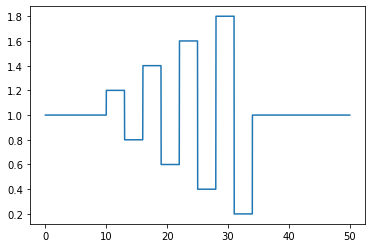

In [4]:
dt=0.01
Iavg=1
T_onoff_inc=np.arange(0,50,dt)
ad=10
du=3
times=4
x_onoff_inc=Iavg*np.ones(len(T_onoff_inc))
for n in range(times):
    onstart=n*int(du*2/dt)+int(ad/dt)
    offstart=(2*n+1)*int(du/dt)+int(ad/dt)
    onend=offstart-1
    offend=(n+1)*int(du*2/dt)-1+int(ad/dt)
    x_onoff_inc[onstart:onend]=Iavg+0.2*(n+1)*Iavg
    x_onoff_inc[offstart:offend]=Iavg-0.2*(n+1)*Iavg
    print(T_onoff_inc[onstart],T_onoff_inc[onend])
plt.plot(T_onoff_inc,x_onoff_inc)

### OU stimuli

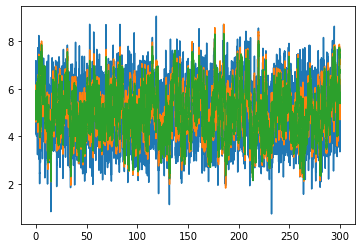

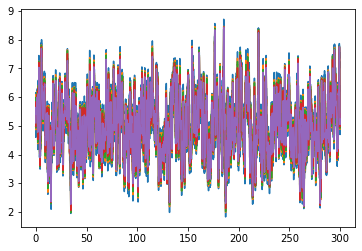

In [5]:
# generate OU input (different tau and different cutoff frequency)
tau_set=[0.1,0.6,1] 
fc_set=['no',10,7,4,2]
Tot=300
dt=0.01
T_OU=np.arange(dt,Tot,dt)
mu, sigma = 0, 1
ran_seed=np.random.normal(mu,sigma,len(T_OU))
x_ou_set=[[[] for i in range(len(fc_set))] for j in range(len(tau_set))]
mean_lumin=5
for i in range(len(tau_set)):
    for j in range(len(fc_set)):
        T_OU,x_ou_set[i][j]=function_NGD_20201022.OU(T_OU,tau_set[i],fc_set[j],ran_seed)
        x_ou_set[i][j]=x_ou_set[i][j]/np.std(x_ou_set[i][j])+mean_lumin

for i in range(len(tau_set)):
    plt.plot(T_OU,x_ou_set[i][0])
# plt.xlim(100,110)
plt.show()
for i in range(len(fc_set)):
    plt.plot(T_OU,x_ou_set[1][i])
# plt.xlim(100,110)
plt.show()

### flickering

(-1.9989000000000001, 41.99889999999999)

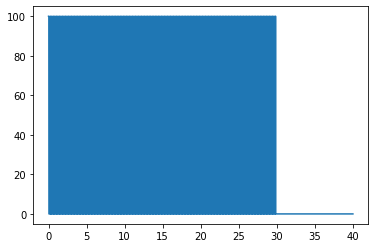

In [6]:
Tot=40
flicker_time=30
dt=0.001
duty=0.2
pulse_period=0.2
pw=pulse_period*duty
T_flicker=np.arange(dt,Tot,dt)
x_flicker=np.zeros(len(T_flicker))
for num_pulse in range(int(np.floor(flicker_time/pulse_period))):
    index_pulse=num_pulse*int(pulse_period/dt)
    for j in range(int(pw/dt)):
        x_flicker[index_pulse+j]=100
    
plt.plot(T_flicker,x_flicker)
plt.xlim()

## Output byEuler method

### ON OFF increasing response

In [7]:
beta_c=7*10**-3
r_onoff_inc,h_onoff_inc,y_onoff_inc,z_onoff_inc=ConeOutput(T_onoff_inc,x_onoff_inc,1,beta_c)
# rb,hb,yb,zb=ConeOutput(x,0,beta_c,dt)

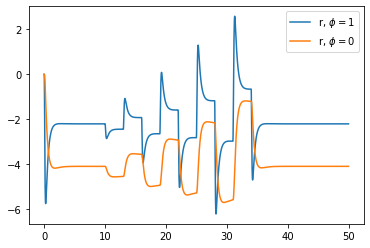

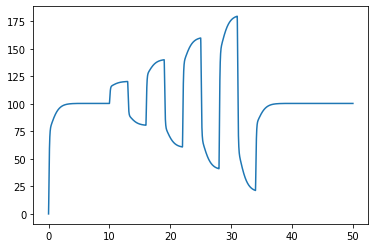

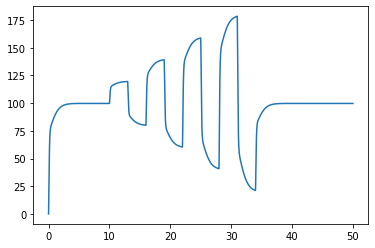

In [8]:
# plt.plot(T,x/np.std(x))
plt.plot(T_onoff_inc,r_onoff_inc/np.std(r_onoff_inc))
plt.plot(T_onoff_inc,h_onoff_inc/np.std(h_onoff_inc))
plt.xlim()
plt.ylim()
plt.legend(('r, $\phi=1$','r, $\phi=0$','h'))
plt.show()


plt.plot(T_onoff_inc,(1+beta_c)*z_onoff_inc)
plt.show()

plt.plot(T_onoff_inc,z_onoff_inc)

### OU reponse

(-0.0011344981576706938, 5.4023721793842565e-05)

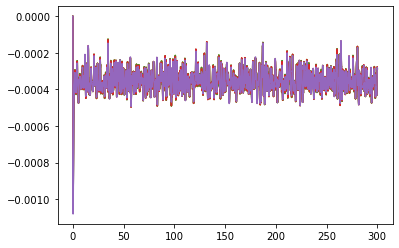

In [9]:
r_ou=[[] for i in range(len(fc_set))]
for i in range(len(fc_set)):
        r_ou[i],h_ou,y_ou,z_ou=ConeOutput(T_OU,x_ou_set[1][i],1,beta_c)
# rb,hb=ConeOutput(x,0,beta_c,dt)
for i in range(len(fc_set)):
    plt.plot(T_OU,r_ou[i])
plt.xlim()
plt.ylim()

-0.04999999999999993
-0.04999999999999993
-0.040000000000000036
-0.030000000000000027
0.030000000000000027


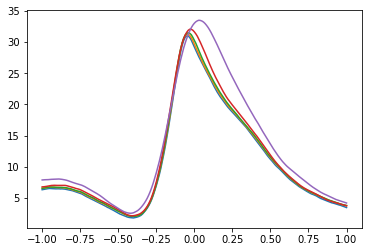

In [10]:
for i in range(len(fc_set)):
    TS,MI1=function_NGD_20201022.MI(function_NGD_20201022.EqualState(x_ou_set[2][i],8),function_NGD_20201022.EqualState(r_ou[i],8),0.01,[-1,1])
    plt.plot(TS,MI1)
    print(TS[np.argmax(MI1)])

### flickering response

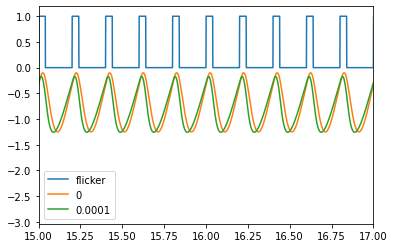

In [11]:
beta_c2=[0,10**-4] #,7*10**-4,7*10**-3
plt.plot(T_flicker,x_flicker/max(x_flicker),label='flicker')
for i in range(len(beta_c2)):
    r_flicker,h_flicker,y_flicker,z_flicker=ConeOutput(T_flicker,x_flicker,1,beta_c2[i])
    plt.plot(T_flicker,r_flicker/max(r_flicker),label=str(beta_c2[i]))
plt.xlim(15,17)
plt.legend()

(10.0, 12.0)

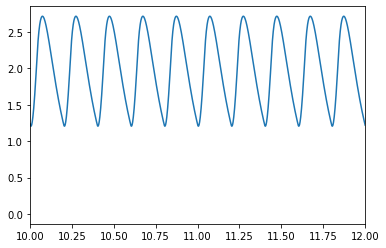

In [12]:
plt.plot(T_flicker,beta_c2[i]*z_flicker)
plt.xlim(10,12)

## Runge-Kutta

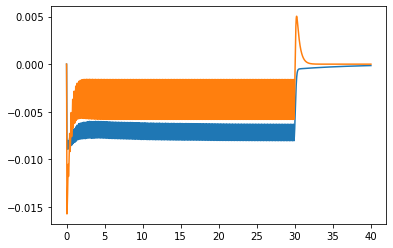

Text(0.5, 1.0, 'phase diagram of RK')

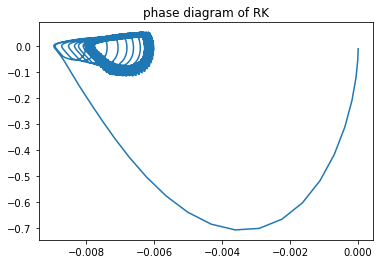

In [13]:
# RK output
beta_c3=0.7*10**-3
T_RK,x_RK,r_RK,h_RK=ConeOutput_RK(T_flicker,x_flicker,1,beta_c3)
r_eu,h_eu,y_eu,z_eu=ConeOutput(T_flicker,x_flicker,1,beta_c3)
plt.plot(T_RK,r_RK)
plt.plot(T_flicker,r_eu)
# plt.xlim(0,2)
plt.show()

vr_flicker=np.diff(r_RK)/dt
plt.plot(r_RK[:-10000],vr_flicker[:-9999])
plt.title('phase diagram of RK')

### runge kutta scipy